# Introduction: Business Problem 

In this project we will try to predict the monthly rental price for a condominium. Specifically, this report will be targeted to stakeholders interested in finding the best value in renting a condominium in Singapore.

We will use our data science powers to find optimum rental price and recommend stake holders the best values and similar units for the stakeholders.

# Data Acquisition

Based on definition of our problem, factors that will influence a housing price could be:

1. Size of the unit
2. Furnishing Level of the Unit
3. Location of the unit
4. Proximity of the unit to public transportation
5. Remaining least of the unit / How new the unit is

etc....

In this section, we will retrieve the unit-wise detailes , size of the units, furnishing level of the units, proximity of the units to public transportation & remaining least of the unit by web-scrapping 99.co. 

As 99.co uses javascript, we need to use **Selenium** for our scraping.

Our scraping strategy will be following this sequence

1. Access to 99co condominium rental housing webpage
2. Finding out the total pages available to scrape
3. Retrieve the link to each
4. Create a for loop to retrieve each link at a single page and scraped the detailed inside the listing
5. do it for all the available pages

**Step-1**: Access to 99co condominium rental housing webpage
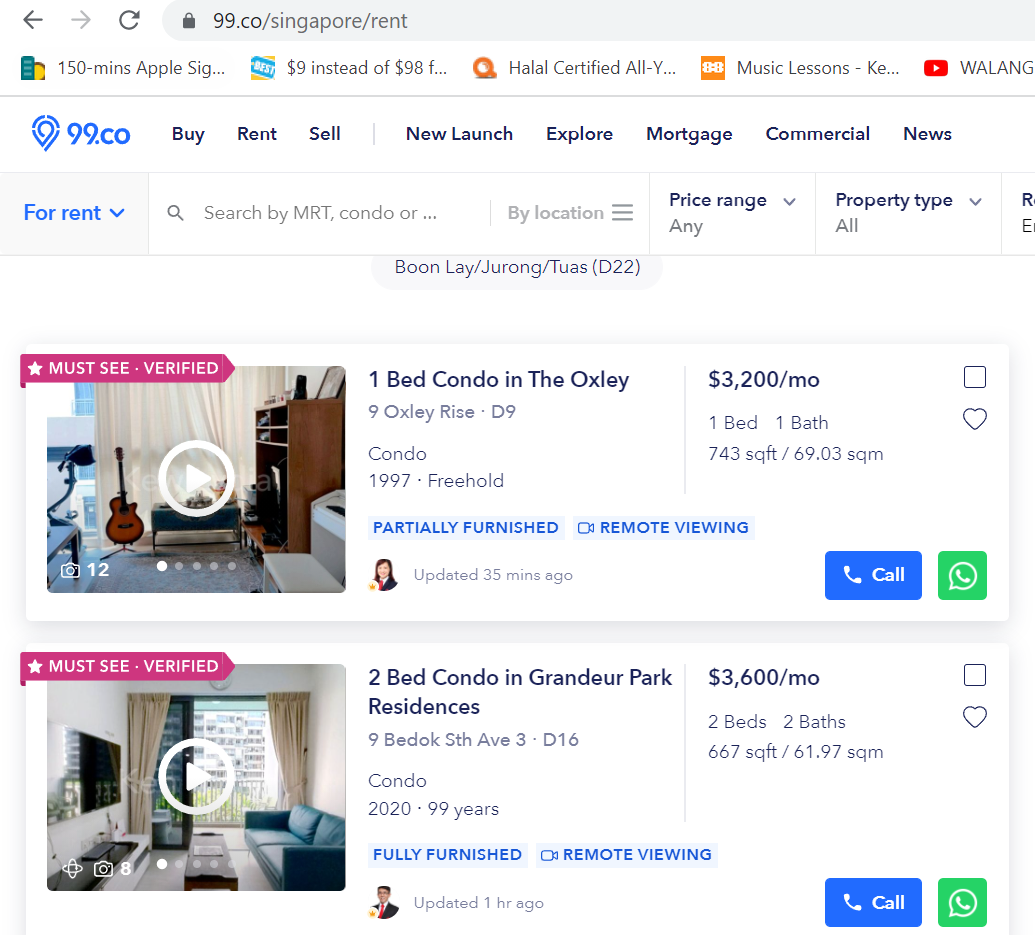

**Step-2**: Finding out the total pages available to scrape
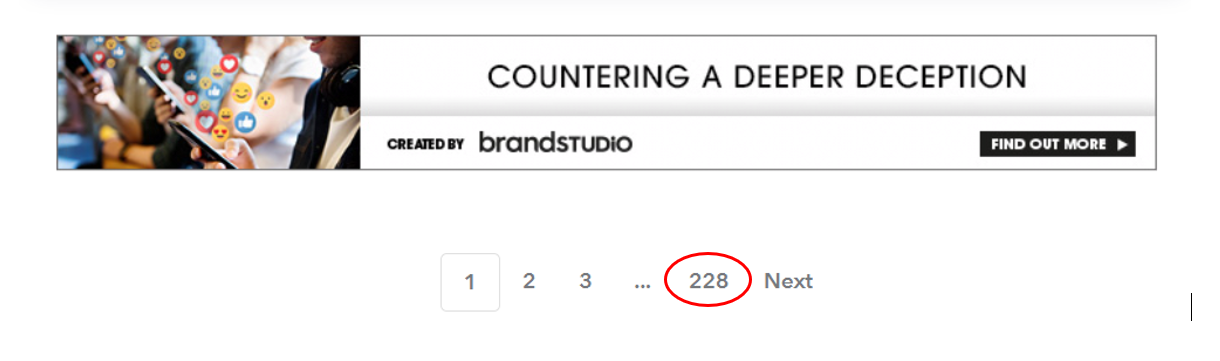

**Step-3 & Step-4** : Retrieve link and scrape each information within a listing
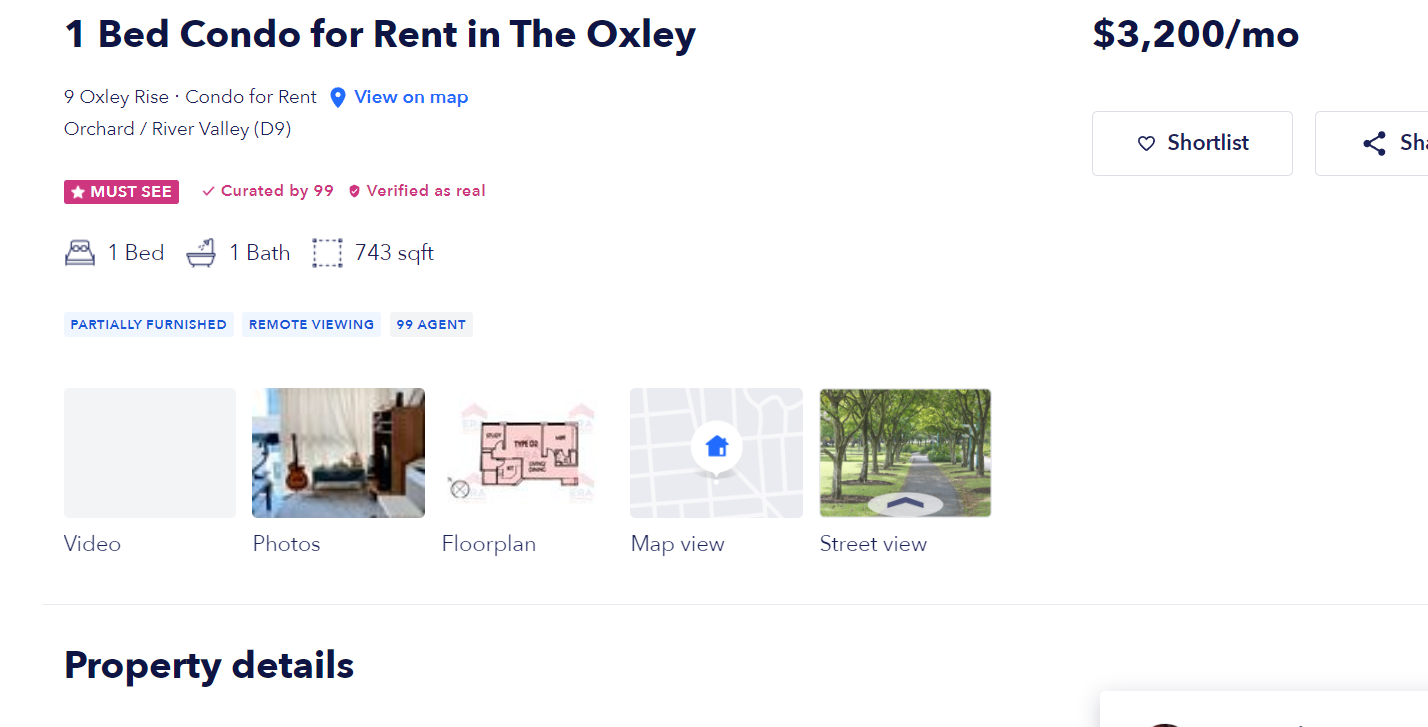

Step 5: Do it for all pages.

# Important and Setting up selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

import time
import numpy as np
import pandas as pd

## Accessing to 99co condominium rental Page

In [ ]:
# Set webdriver options
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('ignore-certificate-errors')

#close any opened driver
try:
    driver.close() 
except Exception:
    pass

# Initiate webdriver
driver = webdriver.Chrome(r'C:\Users\josep\Desktop\Capstone 4\Data\chromedriver', options=options)

#indicate scraping start page
start_page = 206
last_page = 228

url = f'https://www.99.co/singapore/rent/condos-apartments'
driver.get(url+f'?page_num={start_page}')

## Functions of getting all link in one page and scraping unit for one listing

In [47]:
def get_link_in_page():

    """
    Get all the house link in for a given page
    """
    links = driver.find_elements_by_xpath("//div[@class='_2kH6B']//a[contains(@href,'')]")
    house_links = [link.get_attribute("href") for link in links]
    return house_links



In [49]:
def scrape_one_listing(link):
    
    listing_detailed = dict()
    # WebDriverWait(driver, 60).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="price"]/h2')))
    
    class_name = '_2sIc2 _29qfj _2rhE-'
    WebDriverWait(driver, 60).until(expected_conditions.presence_of_element_located((By.XPATH, f'//*[@class="{class_name}"]')))

    # note, I have tried using direct xpath, however the way each information structured is not consistence between website. 
    #Hence it is not recommended to use direct xpath, instead we should scrape via attribute level eg class etc.
    
    listing_detailed['link'] = link
    #main header
    try:listing_detailed['price_month'] = driver.find_element_by_xpath('//*[@id="price"]/h2').text
    except:listing_detailed['price_month'] = np.nan
    
 
    #Property details
    elems = driver.find_elements_by_xpath(f"//p[@class='_2sIc2 _29qfj _2rhE-']")    
    details = [elem.text.split(" ") for elem in elems]
    for sub_list in details:
        if len(sub_list) == 1:
            listing_detailed[f"{sub_list[0].lower()}"] = sub_list[0].lower() # This is to cater to Studio label
        else:
            listing_detailed[f"{sub_list[1].lower()}"] = sub_list[0] # Catering to the other property details e.g. no. of baths

    try:listing_detailed['detailed_address'] = driver.find_element_by_xpath('//*[@id="overview"]/div/div[2]/div[1]/p/span[1]').text
    except:listing_detailed['detailed_address'] =  np.nan

    try:listing_detailed['district'] = driver.find_element_by_xpath('//*[@id="overview"]/div/div[2]/div[1]/p/span[3]').text
    except:listing_detailed['district'] =  np.nan

    #property details
    # This section will take into account these details (if present): Availability, Lease, Furnishing, Property Type, 
    # Name, Unit Types, Total Units, Built Year, Tenure, Developer, and Neighbourhood
    class_name_td1 = '_3r4yN NomDX'
    class_name_td2 = '_3r4yN XCAFU'
    num_of_property_details = len(driver.find_elements_by_xpath(f"//div[contains(@class, '{class_name_td1}')]"))
    for i in range(num_of_property_details):
        detail_category = driver.find_elements_by_xpath(f"//div[contains(@class, '{class_name_td1}')]")[i].text
        detail_category = detail_category.lower()
        detail_category = detail_category.replace(" ","_")
        listing_detailed[f'{detail_category}'] = driver.find_elements_by_xpath(f"//div[@class='{class_name_td2}']")[i].text    
    #picture url

    try:listing_detailed['picture_url'] = driver.find_element_by_xpath('//*[@id="listingPageContent"]/div[1]/div[1]/div[2]/div/div[1]/img').get_attribute('src')
    except:listing_detailed['picture_url'] = np.nan
    
    #mrt
    try:
        listing_detailed['mrt_distance'] = driver.find_element_by_xpath('//*[@id="listingPageContent"]/div[1]/div[1]/div[1]/div[2]/p/span').text
        listing_detailed['mrt_name'] = driver.find_element_by_xpath('//*[@id="listingPageContent"]/div[1]/div[1]/div[1]/div[2]/p/a').text
    except:
        listing_detailed['mrt_distance'] = np.nan
        listing_detailed['mrt_name'] = np.nan
        
    #Amenities
    # Expand amenities
    try:
        driver.find_element_by_xpath('//*[@id="listingPageContent"]/div[1]/div[1]/div[3]/button/span').click()
    
    #wait until button expanded 
        WebDriverWait(driver, 60).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="listingPageContent"]/div[1]/div[1]/div[3]/button')))
    except: pass
    #extractall amenities
    amenities_elems = driver.find_elements_by_xpath("//p[@class='_2sIc2 _2rhE-']")
    try: listing_detailed['amenities'] = [ele.text for ele in amenities_elems]
    except: listing_detailed['amenities'] = np.nan

    return listing_detailed

## Start Scraping

In [50]:
#
try:
    scraped_df = pd.read_csv('scraped_df3.csv')
    print("Existing Data Found")
except:
    scraped_df = pd.DataFrame()

for _ in range(start_page, last_page+1):
    current_page = WebDriverWait(driver, 30).until(expected_conditions.presence_of_element_located((By.XPATH, "//li[@class='active']"))).text
    current_page = int(current_page)
    print(current_page)
    if current_page <= last_page:
        links = get_link_in_page()
        for pg, link in enumerate(links):
            driver.get(link)
            listing_dict = scrape_one_listing(link)
            scraped_df = scraped_df.append(listing_dict, ignore_index=True)
            time.sleep(0.5)
            print(f"Completed {pg+1} out of {len(links)} links of Page {current_page}")
        start_page = start_page + 1
        print("Next Page is ", start_page)
        scraped_df.to_csv('scraped_df3.csv', index=False)
        driver.get(url+f'?page_num={start_page}')

            

Existing Data Found
206
Completed 1 out of 35 links of Page 206
Completed 2 out of 35 links of Page 206
Completed 3 out of 35 links of Page 206
Completed 4 out of 35 links of Page 206
Completed 5 out of 35 links of Page 206
Completed 6 out of 35 links of Page 206
Completed 7 out of 35 links of Page 206
Completed 8 out of 35 links of Page 206
Completed 9 out of 35 links of Page 206
Completed 10 out of 35 links of Page 206
Completed 11 out of 35 links of Page 206
Completed 12 out of 35 links of Page 206
Completed 13 out of 35 links of Page 206
Completed 14 out of 35 links of Page 206
Completed 15 out of 35 links of Page 206
Completed 16 out of 35 links of Page 206
Completed 17 out of 35 links of Page 206
Completed 18 out of 35 links of Page 206
Completed 19 out of 35 links of Page 206
Completed 20 out of 35 links of Page 206
Completed 21 out of 35 links of Page 206
Completed 22 out of 35 links of Page 206
Completed 23 out of 35 links of Page 206
Completed 24 out of 35 links of Page 206
C

## Save scraped information for further processing

In [ ]:
# #drop duplicate
# scraped_df = scraped_df.drop_duplicates()
# scraped_df.to_csv('Data/scraped_df3.csv', index=False)